In [199]:
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from yellowbrick.classifier import ClassificationReport, ConfusionMatrix


import pandas as pd

from matplotlib import pyplot

## TODO:

- check for information leakage/over fitting etc
- hyperparameter tuning
- more features
- feature importances
- combine prime/opt team results  for round predictor

In [2]:
df = pd.read_parquet('../data/raw/features.parquet', use_pandas_metadata=True)
df.columns

Index(['season', 'round', 'venue', 'date', 'prime_team', 'prime_team_points',
       'opt_team', 'opt_team_points', 'home_away', 'prime_margin', 'result',
       'prime_margin_1', 'prime_margin_2', 'prime_margin_3', 'prime_margin_4',
       'prime_margin_5', 'prime_margin_6', 'pm_l6w'],
      dtype='object')

In [3]:
df.head()

,season,round,venue,date,prime_team,prime_team_points,opt_team,opt_team_points,home_away,prime_margin,result,prime_margin_1,prime_margin_2,prime_margin_3,prime_margin_4,prime_margin_5,prime_margin_6,pm_l6w
0,2018,25,"Stadium Australia, Sydney",2018-08-30,Rabbitohs,51.0,Wests Tigers,10.0,home,41.0,1.0,-12.0,-20.0,-4.0,10.0,6.0,-16.0,-6.000000
1,2018,25,"Mt Smart Stadium, Auckland",2018-08-31,Warriors,20.0,Raiders,16.0,home,4.0,1.0,20.0,-1.0,16.0,6.0,-24.0,-6.0,1.833333
2,2018,25,"AAMI Park, Melbourne",2018-08-31,Storm,16.0,Panthers,22.0,home,-6.0,-1.0,2.0,16.0,-3.0,-10.0,34.0,6.0,7.500000
3,2018,25,"McDonald Jones Stadium, Newcastle",2018-09-01,Knights,14.0,Dragons,24.0,home,-10.0,-1.0,-26.0,8.0,-16.0,-9.0,-2.0,6.0,-6.500000
4,2018,25,"Cbus Super Stadium, Gold Coast",2018-09-01,Titans,26.0,Cowboys,30.0,home,-4.0,-1.0,-2.0,8.0,-1.0,-16.0,24.0,-6.0,1.166667


In [107]:
df.dtypes

season                  int64
round                   int64
venue                category
date                   object
prime_team           category
prime_team_points     float64
opt_team             category
opt_team_points       float64
home_away            category
prime_margin          float64
result                float64
prime_margin_1        float64
prime_margin_2        float64
prime_margin_3        float64
prime_margin_4        float64
prime_margin_5        float64
prime_margin_6        float64
pm_l6w                float64
dtype: object

In [4]:
y_cols = 'result'
X_cols = ['prime_team', 'home_away', 'opt_team', 'venue', 'prime_margin_1', 'prime_margin_2', 'prime_margin_3', 
          'prime_margin_4', 'prime_margin_5', 'prime_margin_6', 'pm_l6w']

In [5]:
history_df=df.loc[(df.result!=0) & ~df.result.isna(), :] # drop out the two draws, we're not trying to predict those so lets keep this binary
categories = {-1: 0, 1:1}

In [6]:
X_df = history_df.loc[:, X_cols]
y_df = history_df.loc[:, y_cols]
y_df = y_df.replace(categories)

In [7]:
seed = 10
test_size = 0.33

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_size, random_state=seed)
#eval_set = [(X_test, y_test)]
eval_set = [(X_train, y_train), (X_test,y_test)]

[0]	validation_0-error:0.27500	validation_1-error:0.40196
[1]	validation_0-error:0.24839	validation_1-error:0.36928
[2]	validation_0-error:0.23548	validation_1-error:0.35458
[3]	validation_0-error:0.23629	validation_1-error:0.34804
[4]	validation_0-error:0.23952	validation_1-error:0.33824
[5]	validation_0-error:0.23790	validation_1-error:0.34314
[6]	validation_0-error:0.23790	validation_1-error:0.34314
[7]	validation_0-error:0.22823	validation_1-error:0.34477
[8]	validation_0-error:0.22581	validation_1-error:0.34314
[9]	validation_0-error:0.22258	validation_1-error:0.34150
[10]	validation_0-error:0.22500	validation_1-error:0.33497
[11]	validation_0-error:0.22581	validation_1-error:0.33170
[12]	validation_0-error:0.22419	validation_1-error:0.32190
[13]	validation_0-error:0.22742	validation_1-error:0.32516
[14]	validation_0-error:0.21694	validation_1-error:0.32516
[15]	validation_0-error:0.21694	validation_1-error:0.33007
[16]	validation_0-error:0.21048	validation_1-error:0.32843
[17]	va

/home/chris/miniconda3/envs/datasci/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


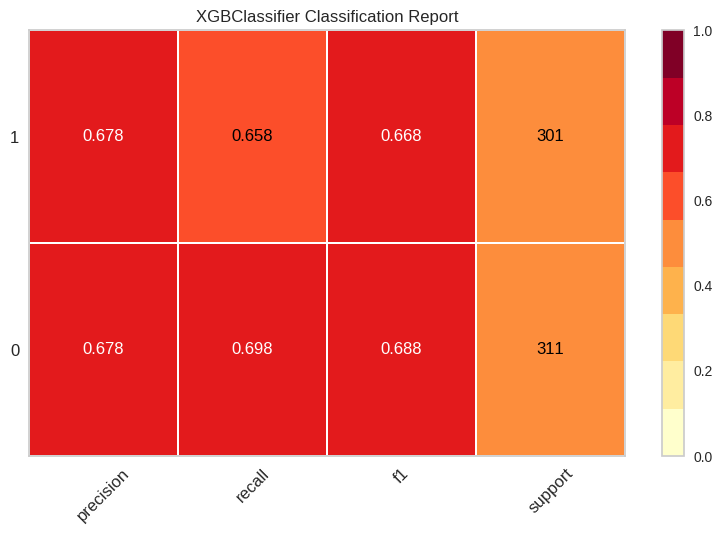

<AxesSubplot: title={'center': 'XGBClassifier Classification Report'}>

In [204]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
clf = XGBClassifier(tree_method="gpu_hist", 
                    #booster='dart',
                    enable_categorical=True, 
                    eval_metric="error",
                    early_stopping_rounds=15, 
                    n_estimators=30, 
                    learning_rate=0.1, 
                    gamma=6,
                    eta=0.01,
                    max_depth=8,
                    verbosity=1, 
                    subsample=0.9,
                    #colsample_bytree=0.9,
                    #colsample_bynode=0.9
                   )


# X is the dataframe we created in previous snippet
clf.fit(X_train, y_train,  
        eval_set=eval_set, 
        verbose=True, )


#clf = GaussianNB()
cr = ClassificationReport(clf, classes=[0,1], support=True, is_fitted=True)
cr.score(X_test, y_test)        # Evaluate the model on the test data
cr.show()                       # Finalize and show the figure

/home/chris/miniconda3/envs/datasci/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


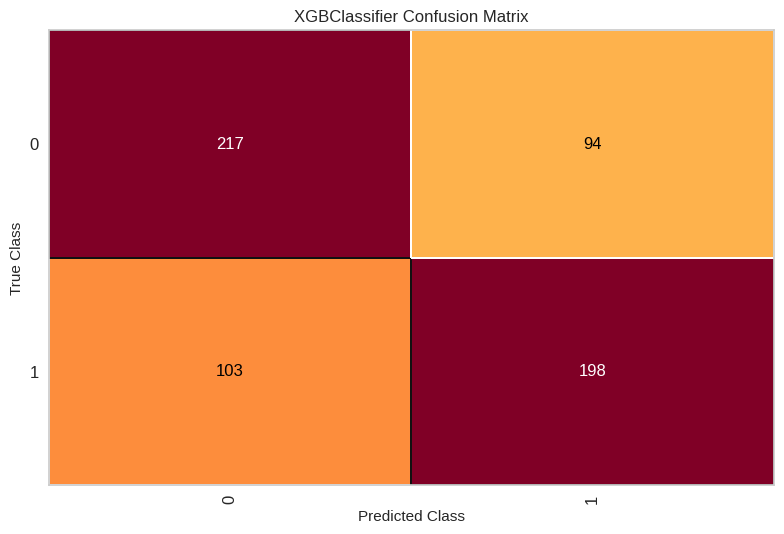

<AxesSubplot: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [203]:
cm = ConfusionMatrix(clf, classes=[0,1], is_fitted=True)
# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()


In [205]:
predictions = clf.predict(X_test)

In [206]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 67.81%


In [207]:
f1 = f1_score(y_test, predictions)
print("F1: %.2f%%" % (f1 * 100.0))

F1: 66.78%


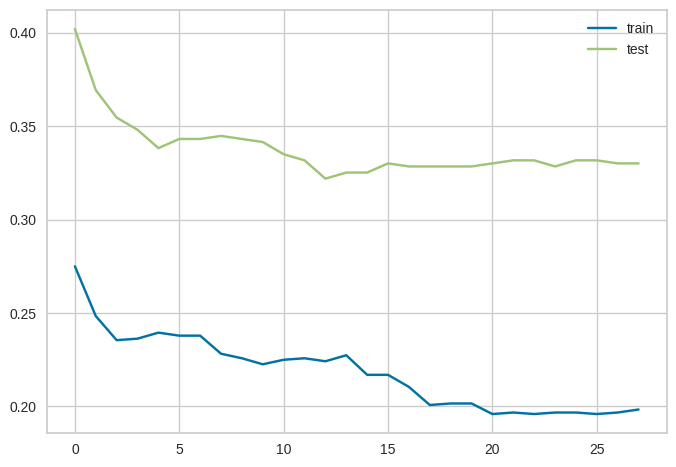

In [208]:
results = clf.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['error'], label='train')
pyplot.plot(results['validation_1']['error'], label='test')
# show the legend
pyplot.legend()
#pyplot.ylim(0,0.4)
# show the plot
pyplot.show()

In [209]:
nr_pred=clf.predict(df.loc[(df.season==2023) & 
                   (df['round']==1), X_cols])
nr_pred_proba=clf.predict_proba(df.loc[(df.season==2023) & 
                                       (df['round']==1), X_cols])

In [210]:
next_round = df.loc[(df.season==2023) & 
       (df['round']==1), X_cols]

In [211]:
next_round.assign(pred = nr_pred).assign(pred_proba_0 = nr_pred_proba[:, 0], pred_proba_1=nr_pred_proba[:, 1]).sort_values('venue')

,prime_team,home_away,opt_team,venue,prime_margin_1,prime_margin_2,prime_margin_3,prime_margin_4,prime_margin_5,prime_margin_6,pm_l6w,pred,pred_proba_0,pred_proba_1
1127,Sea Eagles,home,Bulldogs,"4 Pines Park, Sydney",-1.0,-42.0,-34.0,-20.0,-16.0,-10.0,-20.500000,1,0.427958,0.572042
2259,Bulldogs,away,Sea Eagles,"4 Pines Park, Sydney",1.0,-16.0,-36.0,-24.0,-14.0,14.0,-12.500000,0,0.624274,0.375726
1126,Panthers,home,Broncos,"BlueBet Stadium, Penrith",-30.0,34.0,4.0,-16.0,20.0,-24.0,-2.000000,1,0.302135,0.697865
2258,Broncos,away,Panthers,"BlueBet Stadium, Penrith",-10.0,-47.0,-48.0,18.0,-18.0,-14.0,-19.833333,0,0.785918,0.214082
1124,Eels,home,Storm,"CommBank Stadium, Sydney",8.0,47.0,36.0,-26.0,16.0,24.0,17.500000,1,0.423213,0.576787
2256,Storm,away,Eels,"CommBank Stadium, Sydney",-8.0,-4.0,48.0,16.0,18.0,12.0,13.666667,1,0.413540,0.586460
1131,Wests Tigers,home,Titans,"Leichhardt Oval, Sydney",-46.0,-2.0,-66.0,-24.0,-4.0,14.0,-21.333333,0,0.544641,0.455359
2263,Titans,away,Wests Tigers,"Leichhardt Oval, Sydney",1.0,10.0,-20.0,20.0,-18.0,-12.0,-3.166667,1,0.462831,0.537169
1129,Sharks,home,Rabbitohs,"PointsBet Stadium, Sydney",22.0,16.0,34.0,24.0,6.0,1.0,17.166667,1,0.451848,0.548152
2261,Rabbitohs,away,Sharks,"PointsBet Stadium, Sydney",-10.0,10.0,-4.0,26.0,38.0,-1.0,9.833333,1,0.481661,0.518339
